In [0]:
# connecting google drive with google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# setup
**installments_payment**: 
- payment history for previous loans at Home Credit. 
- There is one row for every made payment and one row for every missed payment. 

In [0]:
import os
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:
DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
df_pay = pd.read_csv(os.path.join(DATA_DIRECTORY, 'installments_payments.csv'), nrows= None)
df_pay.head()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [0]:
# This function assits to expand Exploratory Data Analysis (EDA) is an open-ended 
#process where we calculate statistics and make figures to find trends, anomalies,
#patterns, or relationships within the data. The goal of EDA is to learn what our
#data can tell us. It generally starts out with a high level overview, 
#then narrows in to specific areas as we find intriguing areas of the data. 

def statistical_analyzing(df_input):
  # check number of rows, cols
  no_rows = df_input.shape[0]
  no_cols = df_input.shape[1]
  print("No. observations:", no_rows )
  print("No. features:", no_cols )
  
  # checking type of features
  name = []
  cols_type = []
  for n,t in df_input.dtypes.iteritems():
    name.append(n)
    cols_type.append(t)
    
  # checking distinction (unique values) of features
  ls_unique = []
  for cname in df_input.columns:
    try:
      nunique = df_input[cname].nunique()
      pct_unique = nunique*100.0/ no_rows
      ls_unique.append("{} ({:0.2f}%)".format(nunique, pct_unique))
    except:
      ls_unique.append("{} ({:0.2f}%)".format(0,0))
      continue
  # checking missing values of features
  ls_miss = []
  for cname in df_input.columns:
    try:
      nmiss = df_input[cname].isnull().sum()
      pct_miss = nmiss*100.0/ no_rows
      ls_miss.append("{} ({:0.2f}%)".format(nmiss, pct_miss))
    except:
      ls_miss.append("{} ({:0.2f}%)".format(0,0))
      continue 
      
  # checking zeros
  ls_zeros = []
  for cname in df_input.columns:
    try:
      nzeros = (df_input[cname] == 0).sum()
      pct_zeros = nzeros * 100.0/ no_rows
      ls_zeros.append("{} ({:0.2f}%)".fornat(nzeros, pct_zeros))
    except:
      ls_zeros.append("{} ({:0.2f}%)".format(0,0))
      continue
      
  # checking negative values
  ls_neg = []
  for cname in df_input.columns:
    try:
      nneg = (df_input[cname].astype("float")<0).sum()
      pct_neg =nneg * 100.0 / no_rows
      ls_neg.append("{} ({:0.2f}%)".format(nneg, pct_neg))
    except:
      ls_neg.append("{} ({:0.2f}%)".format(0,0))
      continue
      
  # extracting the output
  data = {
      "name": name,
      "col_type": cols_type,
      "n_unique": ls_unique,
      "n_miss": ls_miss,
      "n_zeros":ls_zeros,
      "n_neg":ls_neg      
  }
  
  # statistical info
  df_stats = df_input.describe().transpose()
  ls_stats = []
  for stat in df_stats.columns:
    data[stat] = []
    for cname in df_input.columns:
      try:
        data[stat].append(df_stats.loc[cname, stat])
      except:
        data[stat].append(0.0)
        
  # take samples
  df_sample = df_input.sample(frac = .5).head().transpose()
  df_sample.columns = ["sample_{}".format(i) for i in range(5)]
  
  # repair the output
  col_ordered = ["name","col_type","n_unique","n_miss","n_zeros","n_neg",
                "25%","50%","75%","count","max","mean","min","std"]
  df_data = pd.DataFrame(data, columns = col_ordered).set_index("name")
  df_data = pd.concat([df_data, df_sample], axis = 1)
  
  return df_data   

In [0]:
def plot_categorical(cols, target, df):
  for col in cols:
    if target == None:
      sns.countplot(x=col, data=df[[col]] ,  palette="Reds_d")      
    else:
      print('Column name: %s' %col)
      sns.countplot(x=col, hue=target, data=df[[col,target]], palette="Reds_d")
      #sns.barplot(x=col, y=target, data=df[[col,target]]
      #        , palette="Reds_d", estimator = sum)
      plt.legend()
    plt.xticks(rotation=90)#-60    
    plt.show()

# Plotting the continous features :    
# 1. A box plot (or box-and-whisker plot) shows the distribution of quantitative data 
#in a way that facilitates comparisons between variables.
# 2. Distribution graph :to check the linearity of the variables and look for skewness of features.
def plot_continous(cols, target, df):
  # Using boxplot to analyze the continous feature
  for col in cols:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    if target == None:
      plot = sns.boxplot(col, whis=1.5, data=df)
    else:
      plot = sns.boxplot(x=target, y=col, whis=1.5, data=df)
      plt.legend()
    # which defined as the proportion of the IQR past the low and high quartiles to extend the plot whiskers 
    # or interquartile range (IQR)
    # therefore, maximum = Q3 + 1.5*IQR , min = Q1 - 1.5*IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print('Column name: %s' %col)    
    print('> No.outliner: %d \n' %((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum())
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(df[col].dropna())#.hist(bins=20)
    fig.set_ylabel('Volumn')
    fig.set_xlabel(col)    
    plt.show() 

In [0]:
df_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [0]:
# df_explore_cate = statistical_analyzing(df_pay)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#   print(df_pay.columns)
#   print(df_explore_cate)

statistical_analyzing(df_pay)

No. observations: 13605401
No. features: 8


,col_type,n_unique,n_miss,n_zeros,n_neg,25%,50%,75%,count,max,mean,min,std,sample_0,sample_1,sample_2,sample_3,sample_4
name,,,,,,,,,,,,,,,,,,
SK_ID_PREV,int64,997752 (7.33%),0 (0.00%),0 (0.00%),0 (0.00%),1434191.000,1896520.000,2369094.000,13605401.0,2843499.000,1.903365e+06,1000001.0,536202.905546,1050401.00,2036132.000,2128005.000,2080649.000,1544990.000
SK_ID_CURR,int64,339587 (2.50%),0 (0.00%),0 (0.00%),0 (0.00%),189639.000,278685.000,367530.000,13605401.0,456255.000,2.784449e+05,100001.0,102718.310411,297484.00,302360.000,171666.000,293555.000,442416.000
NUM_INSTALMENT_VERSION,float64,65 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),0.000,1.000,1.000,13605401.0,178.000,8.566373e-01,0.0,1.035216,1.00,1.000,0.000,1.000,1.000
NUM_INSTALMENT_NUMBER,int64,277 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%),4.000,8.000,19.000,13605401.0,277.000,1.887090e+01,1.0,26.664067,1.00,10.000,26.000,7.000,3.000
DAYS_INSTALMENT,float64,2922 (0.02%),0 (0.00%),0 (0.00%),13605401 (100.00%),-1654.000,-818.000,-361.000,13605401.0,-1.000,-1.042270e+03,-2922.0,800.946284,-1002.00,-518.000,-674.000,-60.000,-1405.000
DAYS_ENTRY_PAYMENT,float64,3039 (0.02%),2905 (0.02%),0 (0.00%),13602496 (99.98%),-1662.000,-827.000,-370.000,13602496.0,-1.000,-1.051114e+03,-4921.0,800.585883,-1008.00,-528.000,-674.000,-68.000,-1410.000
AMT_INSTALMENT,float64,902539 (6.63%),0 (0.00%),0 (0.00%),0 (0.00%),4226.085,8884.080,16710.210,13605401.0,3771487.845,1.705091e+04,0.0,50570.254429,2660.31,3749.175,30.375,4716.405,7963.155
AMT_PAYMENT,float64,944235 (6.94%),2905 (0.02%),0 (0.00%),0 (0.00%),3398.265,8125.515,16108.425,13602496.0,3771487.845,1.723822e+04,0.0,54735.783981,2660.31,3749.175,30.375,4716.405,7963.155


In [0]:
cols = list(df_pay.columns)
cols.remove('SK_ID_PREV')
cols.remove('SK_ID_CURR')


# key


In [0]:
statistical_analyzing(df_pay[["SK_ID_CURR","SK_ID_PREV"]])

No. observations: 13605401
No. features: 2


,col_type,n_unique,n_miss,n_zeros,n_neg,25%,50%,75%,count,max,mean,min,std,sample_0,sample_1,sample_2,sample_3,sample_4
name,,,,,,,,,,,,,,,,,,
SK_ID_CURR,int64,339587 (2.50%),0 (0.00%),0 (0.00%),0 (0.00%),189639.0,278685.0,367530.0,13605401.0,456255.0,2.784449e+05,100001.0,102718.310411,173008,237603,380806,285186,361170
SK_ID_PREV,int64,997752 (7.33%),0 (0.00%),0 (0.00%),0 (0.00%),1434191.0,1896520.0,2369094.0,13605401.0,2843499.0,1.903365e+06,1000001.0,536202.905546,1113088,1640074,1002932,2567326,2032134


# Continous

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

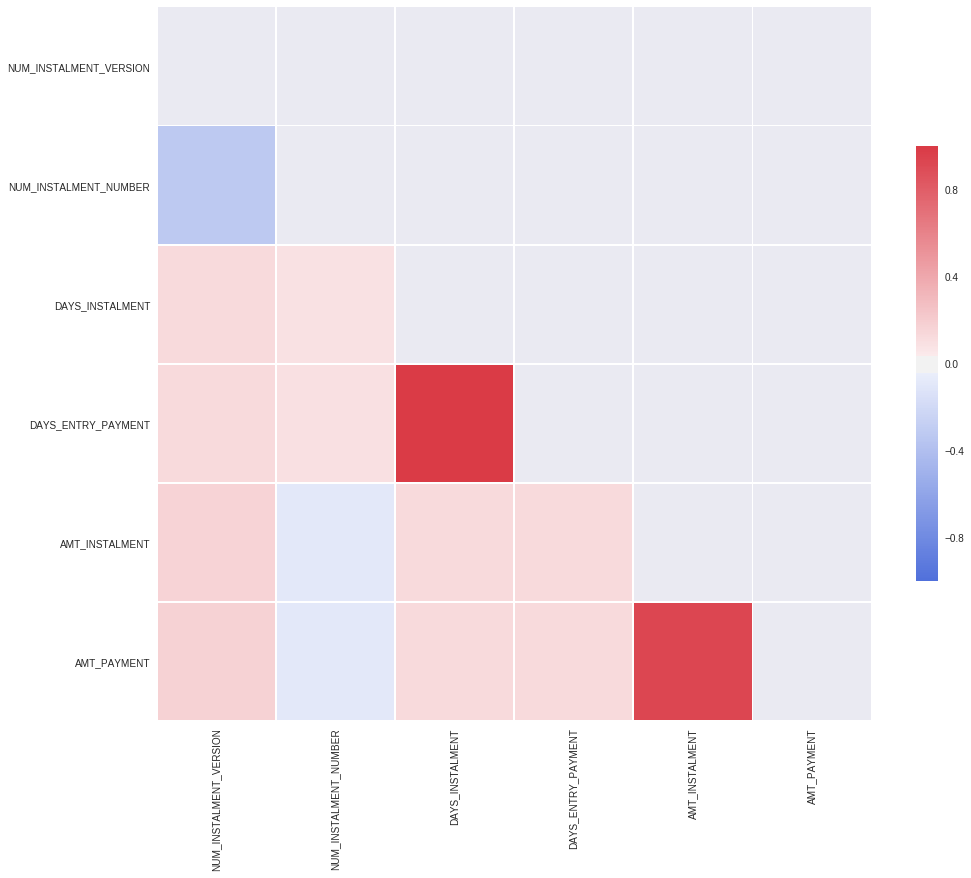

In [0]:
correlations = df_pay[cols].corr()

# Using seaborn package
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmin = -1, vmax= 1 , center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=90)
plt.yticks(rotation=0)
#correlations

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Column name: NUM_INSTALMENT_VERSION
> No.outliner: 417616 



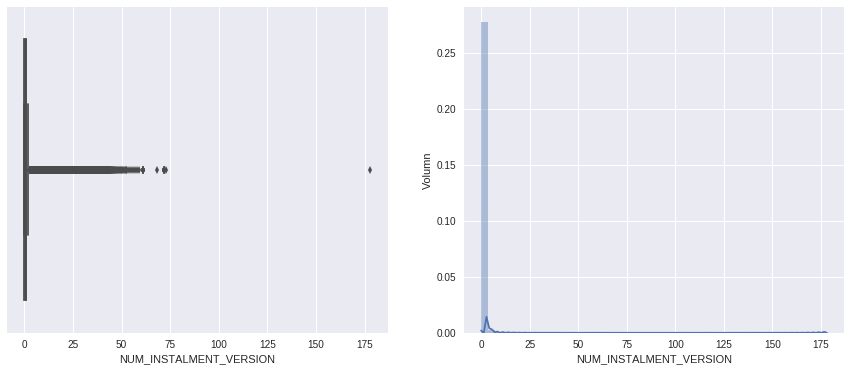

Column name: NUM_INSTALMENT_NUMBER
> No.outliner: 1886320 



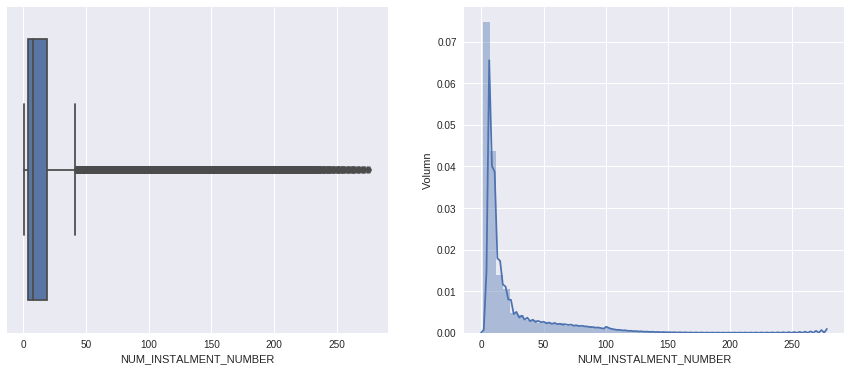

Column name: DAYS_INSTALMENT
> No.outliner: 0 



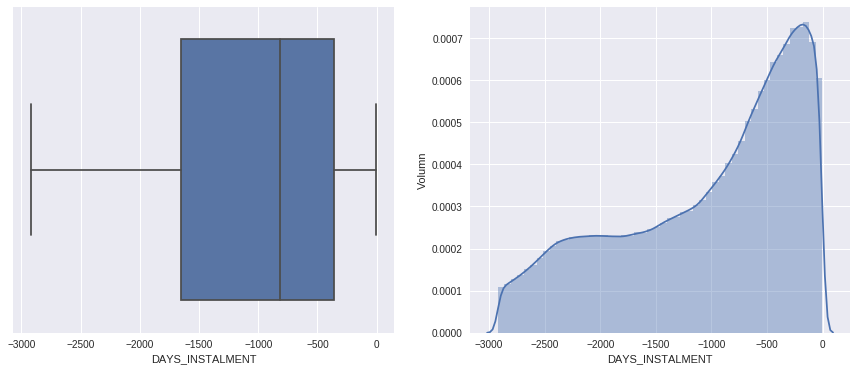

Column name: DAYS_ENTRY_PAYMENT
> No.outliner: 1 



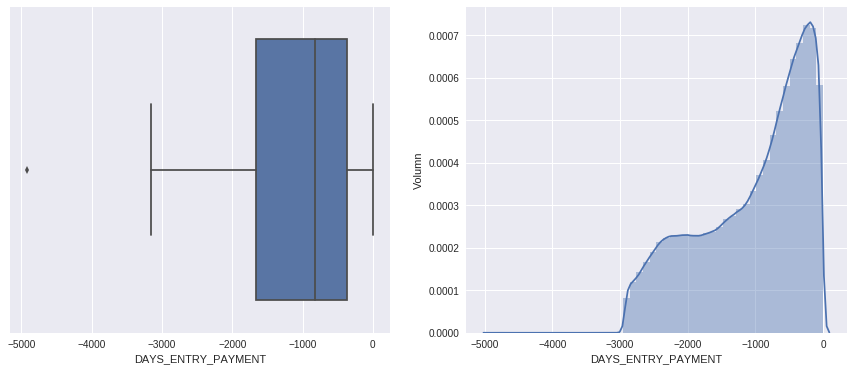

Column name: AMT_INSTALMENT
> No.outliner: 1120800 



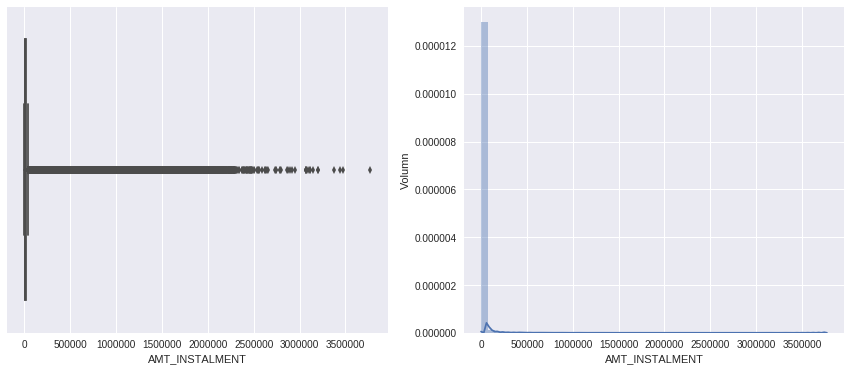

Column name: AMT_PAYMENT
> No.outliner: 1130094 



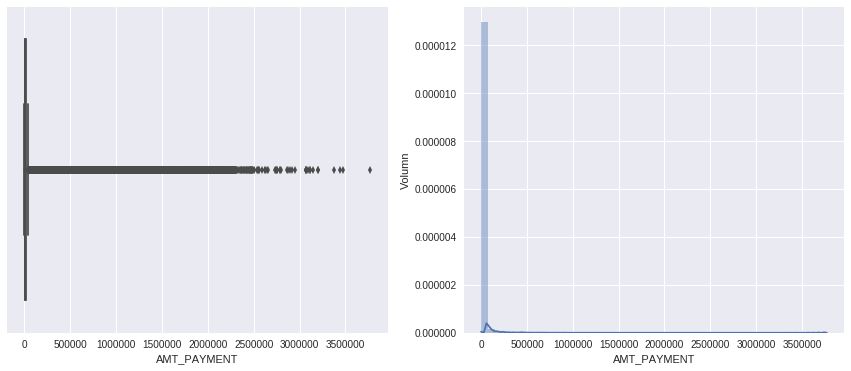

In [0]:
plot_continous(cols, None, df_pay)

#  'NUM_INSTALMENT_VERSION', # systematic code
#  'NUM_INSTALMENT_NUMBER', # systematic code
#  'DAYS_INSTALMENT',   số ngày trả góp
#  'DAYS_ENTRY_PAYMENT',   days of entry payment
#  'AMT_INSTALMENT',  # tiền trả góp
#  'AMT_PAYMENT' # tổng tiền chi trả

# Cleaning

In [0]:
def get_installment_payments(path, num_rows= None):
  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['size', 'nunique'],
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  return pay_agg

# FE
**installments_payment**: 
- Contains 13,605,401 entries, total 8 columns
- payment history for previous loans at Home Credit. 
- There is one row for every made payment and one row for every missed payment. 
- Co hơn 13.6tr điểm dữ liệu, nhưng có ít feature, đặc biệt không có các cột phân loại hợp động/ cân nhắc kết hợp với các table khác để khai thác hết thông tin

**FE**
- Feature Selection is done
- Feature extraction
  - Generating features based on internal data
  - Generating features based on external data
- Domain knowledge features
  - Transformation: Square, Square-Root, Power, Max, Min, Median, Mean, Var ...
  - Feature Calculation: Sum, Minus (Difference), Ratio (Division), Multiplication. Trọng tâm là lấy thông tin về tín dụng của khách hàng trong quá khứ, -> các hệ số khác nên được xây dựng dựa trên feature: 'AMT_CREDIT' 
  - Groupby: 
    - Category feature, 
    - Time-based feature, 'DAYS_DECISION' -> xét theo tháng , days past due (DPD) = DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT
    - Trending feature, Social Network feature.




In [0]:
#  'NUM_INSTALMENT_VERSION', # số thể hiện phiên bản trả góp
#  'NUM_INSTALMENT_NUMBER', # số thể hiện mã của lần trả góp
#  'DAYS_INSTALMENT',   số ngày trả góp
#  'DAYS_ENTRY_PAYMENT',   day of starting payment
#  'AMT_INSTALMENT',  # số tiền phải trả theo trả góp
#  'AMT_PAYMENT' # số tiền chi trả

In [0]:
%%time
pay = df_pay.copy()

# Group payments and get Payment difference
# 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')

# số tiền còn thiếu sau mỗi lần trả góp
pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
# tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
# trả nhiều hơn số tiền cần trả góp
pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
# Percentage of payments that were late
pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))

# Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])

# Flag late payment
pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)

# Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
# trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))

# Percentage of payments that were late
pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                     pay['INSTALMENT_PAYMENT_RATIO'] , 0)

# Flag late payments that have a significant amount
pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
# Flag k threshold late payments (a week, two week)
pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)


CPU times: user 24 s, sys: 1.41 s, total: 25.4 s
Wall time: 25.3 s


In [0]:
INSTALLMENTS_AGG = {
'SK_ID_PREV': ['size', 'nunique'],
'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],     
'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
 # Engineered features
'DPD': ['max', 'mean', 'var'],
'DAYS_DIFF': ['max', 'mean'],
'PAYMENT_DIFFERENCE': ['mean'],
'PAYMENT_RATIO': ['mean'],
'FLAG_LATE_PAYMENT': ['mean', 'sum'],
'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
'LATE_PAYMENT_RATIO': ['mean'],
'DPD_7': ['mean'],
'DPD_15': ['mean'],
'FLAG_PAID_OVER': ['mean'],
'POS_PAYMENT_RATIO':['mean','sum']}

pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

In [0]:
statistical_analyzing(pay_agg)

In [0]:
""" Testing feature """
# ****
df_test = df_pay[df_pay['SK_ID_CURR']== 100002].sort_values(by=['DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT'])

df_test['PAID_OVER_AMOUNT'] = df_test['AMT_PAYMENT'] - df_test['AMT_INSTALMENT']
df_test['FLAG_PAID_OVER'] = (df_test['PAID_OVER_AMOUNT'] > 0).astype(int)

df_test['DPD'] = df_test['DAYS_ENTRY_PAYMENT'] - df_test['DAYS_INSTALMENT']
df_test['DPD'] = df_test['DPD'].apply(lambda x: 0 if x <= 0 else x)
df_test['DBD'] = df_test['DAYS_INSTALMENT'] - df_test['DAYS_ENTRY_PAYMENT']
df_test['DBD'] = df_test['DBD'].apply(lambda x: 0 if x <= 0 else x)
# Flag late payment
df_test['LATE_PAYMENT'] = df_test['DPD'].apply(lambda x: 1 if x > 0 else 0)

df_test
# pay[pay['PAYMENT_RATIO']== float('Inf')][['AMT_INSTALMENT','AMT_PAYMENT_GROUPED','PAYMENT_RATIO']]

In [0]:
# Generating trend feature - NOT DONE
from functools import partial
import multiprocessing as mp
from sklearn.linear_model import LinearRegression

def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features

def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)
    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_

def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features


def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'FLAG_LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'FLAG_PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features
  

In [0]:
group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'FLAG_LATE_PAYMENT',
                  'PAID_OVER_AMOUNT', 'FLAG_PAID_OVER', 'DAYS_INSTALMENT']
#gp = pay[group_features].groupby('SK_ID_CURR')

gr_ = pay[group_features]
gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
features = {}
period = 12
gr_period = gr_.iloc[:period]
add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


{'12_TREND_DPD': nan}

In [0]:
gr_period

,SK_ID_CURR,SK_ID_PREV,DPD,FLAG_LATE_PAYMENT,PAID_OVER_AMOUNT,FLAG_PAID_OVER,DAYS_INSTALMENT
13545386,410746,1887853,0.0,0,0.0,0,-1.0
9270043,309667,1079838,0.0,0,0.0,0,-1.0
12689921,438512,2413546,0.0,0,0.0,0,-2.0
7596340,252259,1058599,NaN,0,NaN,0,-2.0
8169983,376101,1606187,0.0,0,0.0,0,-2.0
7601454,221776,1359220,0.0,0,0.0,0,-2.0
4973572,235086,1720243,0.0,0,0.0,0,-2.0
13585687,422074,1678776,NaN,0,NaN,0,-2.0
7862566,375950,1460815,0.0,0,0.0,0,-2.0
1187703,165758,1235176,0.0,0,0.0,0,-2.0


In [0]:
# Last x periods trend features
group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'FLAG_LATE_PAYMENT',
                  'PAID_OVER_AMOUNT', 'FLAG_PAID_OVER', 'DAYS_INSTALMENT']
gp = pay[group_features].groupby('SK_ID_CURR')
# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]
NUM_THREADS = 4
func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
# pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

# # Last loan features
# g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
# pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

In [0]:
"""Update to function"""
def get_installment_payments_3(path, num_rows= None):  
  """ Process installments_payments.csv and return a pandas dataframe. """
  pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
  
  # Group payments and get Payment difference
  # 'AMT_PAYMENT_GROUPED' với từng lần chi trả thì TỔNG số tiền trả là bao nhiêu?
  pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
  # số tiền còn thiếu sau mỗi lần trả góp
  pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
  # tỉ lệ chi trả = số tiền phải trả / tổng tiền trả
  pay['PAYMENT_RATIO'] = np.where(pay['AMT_PAYMENT_GROUPED'] <= 0, 0, 
                                  (pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']))
  # trả nhiều hơn số tiền cần trả góp
  pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
  pay['FLAG_PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
  # Percentage of payments that were late
  pay['INSTALMENT_PAYMENT_RATIO'] = np.where(pay['AMT_INSTALMENT'] <= 0, 0, 
                                  (pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']))
  # Payment Entry: Days past due (lấy mốc từ hạn, dương là thiếu, âm là dư)
  pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
  pay['DPD'] = np.where(pay['DPD'] <= 0, 0, pay['DPD'])
  pay['DAYS_DIFF'] = abs(pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT'])
  # Flag late payment
  pay['FLAG_LATE_PAYMENT'] = np.where(pay['DPD'] > 0, 1, 0)
  # Khả năng xoay tiền = (số tiền trả)/số giữa ngày tới hạn và ngày chi 
  # trả abs(DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)
  pay['POS_PAYMENT_RATIO'] = np.where(pay['DAYS_DIFF'] <= 0, pay['AMT_PAYMENT'], 
                                  (pay['AMT_PAYMENT'] / pay['DAYS_DIFF']))
  # Percentage of payments that were late
  pay['LATE_PAYMENT_RATIO'] = np.where(pay['FLAG_LATE_PAYMENT'] == 1, 
                                       pay['INSTALMENT_PAYMENT_RATIO'] , 0)
  # Flag late payments that have a significant amount
  pay['SIGNIFICANT_LATE_PAYMENT'] =  np.where(pay['LATE_PAYMENT_RATIO'] > 0.05 ,1,0)
  # Flag k threshold late payments (a week, two week)
  pay['DPD_7'] = np.where(pay['DPD'] >= 7 ,1,0)
  pay['DPD_15'] = np.where(pay['DPD'] >= 15 ,1,0)
  
  INSTALLMENTS_AGG = {
  'SK_ID_PREV': ['nunique'],
  'DAYS_INSTALMENT': ['min', 'max', 'mean'],     
  'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'], 
  'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
  'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
   # Engineered features
  'DPD': ['max', 'mean', 'var'],
  'DAYS_DIFF': ['max', 'mean'],
  'PAYMENT_DIFFERENCE': ['mean'],
  'PAYMENT_RATIO': ['mean'],
  'FLAG_LATE_PAYMENT': ['mean', 'sum'],
  'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
  'LATE_PAYMENT_RATIO': ['mean'],
  'DPD_7': ['mean'],
  'DPD_15': ['mean'],
  'FLAG_PAID_OVER': ['mean'],
  'POS_PAYMENT_RATIO':['mean','sum']}
    
  pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)
  # Aggregations for loans in the last x months
  for time_frame in [12, 24]:    
    time_frame_df = pay[pay['DAYS_ENTRY_PAYMENT'] >= -30*time_frame]
    prefix = 'PAY_LAST{}M_'.format(time_frame)
    PREVIOUS_TIME_AGG = {          
        'AMT_PAYMENT': ['mean','sum'],
        'AMT_INSTALMENT': ['mean', 'max'],
        'DAYS_INSTALMENT': ['min', 'max', 'mean'],
        # Engineered features
        'DPD': ['mean'],
        'PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'FLAG_PAID_OVER': ['mean'],      }
    pay_agg = group_and_merge(time_frame_df, pay_agg, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()
  del prev; gc.collect()
  return pay_agg

In [0]:
%%time
DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

ins = get_installment_payments_3(DATA_DIRECTORY, num_rows)

# Test

In [0]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [0]:
""" FEATURE ENGINEERING FUNCTIONS"""        
def do_mean(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_median(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_std(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df

def do_sum(df, group_cols, counted, agg_name):
  gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
      columns={counted: agg_name})
  df = df.merge(gp, on=group_cols, how='left')
  del gp
  gc.collect()
  return df
  
def label_encoder(df, categorical_columns=None):
  """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
  if not categorical_columns:
      categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
  for col in categorical_columns:
      df[col], uniques = pd.factorize(df[col])
  return df, categorical_columns


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
  """Create a new column for each categorical value in categorical columns. """
  original_columns = list(df.columns)
  if not categorical_columns:# if not auto "ohe" object-type features
      categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
  df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
  categorical_columns = [c for c in df.columns if c not in original_columns]
  return df, categorical_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
  """Grouping by SK_ID_CURR with formated aggregations """
  agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
  # change columns names
  agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                             for e in agg_df.columns.tolist()])
  return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
  agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
  return df_to_merge.merge(agg_df, how='left', on= aggregate_by)
  


In [0]:
# Application table
def get_age_label(days_birth):
  """ Return the age group label (int). """
  age_years = -days_birth / 365
  if age_years < 27: return 1
  elif age_years < 40: return 2
  elif age_years < 50: return 3
  elif age_years < 65: return 4
  elif age_years < 99: return 5
  else: return 0

def get_apply_train_test_2(path, num_rows = None):
  """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
  train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
  test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)    
  df = train.append(test)
  del train, test; gc.collect()

  # Data cleaning
  df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
  df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
  df['DAYS_ID_PUBLISH'].replace(0, np.nan, inplace=True)
  df['DAYS_REGISTRATION'].replace(0, np.nan, inplace=True)

  df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value

  # Categorical age - based on target=1 plot
  df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x)) 

  # Encode categorical features (LabelEncoder)
  df, le_encoded_cols = label_encoder(df, None)
  return df


In [0]:
from contextlib import contextmanager
import time

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_2(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("Credit card dataframe"):
    ins = get_installment_payments(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("ins shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()

Application dataframe shape:  (356250, 123)
application_train and application_test - done in 10s
ins shape:  (339587, 14)
Final dataframe shape:  (356250, 136)
Credit card dataframe - done in 40s


In [0]:
%%time
# Preparing data
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y_1 = train['TARGET']
X_1 = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 500,#2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 100,#200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model_1 = xgb.XGBClassifier(**param_int)
xgb_model_1.fit(X_train,y_train, **param_fit)
evals_result = xgb_model_1.evals_result()
evals_result



Train/valid shape: (356250, 136), test shape: (48744, 136)
[0]	validation_0-auc:0.647582	validation_1-auc:0.640393	validation_2-auc:0.635951
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[100]	validation_0-auc:0.748062	validation_1-auc:0.744533	validation_2-auc:0.742083
[200]	validation_0-auc:0.763373	validation_1-auc:0.755148	validation_2-auc:0.751804
[300]	validation_0-auc:0.774885	validation_1-auc:0.761308	validation_2-auc:0.758053
[400]	validation_0-auc:0.782407	validation_1-auc:0.764259	validation_2-auc:0.761066
[499]	validation_0-auc:0.788134	validation_1-auc:0.765697	validation_2-auc:0.762861
CPU times: user 5min 5s, sys: 7.23 s, total: 5min 12s
Wall time: 2min 46s


In [0]:
# modelling df after added new feature
from contextlib import contextmanager
import time

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

DATA_DIRECTORY = "drive/My Drive/Kaggle/home credit/data/"
#num_rows = 30000 if debug else None
debug = False #True
num_rows = 30000 if debug else None

if __name__ == "__main__":
  with timer("application_train and application_test"):
    df = get_apply_train_test_2(DATA_DIRECTORY, num_rows= num_rows)
    print("Application dataframe shape: ", df.shape)
  with timer("Credit card dataframe"):
    ins = get_installment_payments_3(DATA_DIRECTORY, num_rows)
    df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
    print("ins shape: ", ins.shape)
    print("Final dataframe shape: ", df.shape)
    del ins; gc.collect()

Application dataframe shape:  (356250, 123)
application_train and application_test - done in 8s
ins shape:  (339587, 31)
Final dataframe shape:  (356250, 153)
Credit card dataframe - done in 75s


In [0]:
%%time
# Preparing data
train = df[df['TARGET'].notnull()]
test = df[df['TARGET'].isnull()]
print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))

# spliting data
del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
predictors = list(filter(lambda v: v not in del_features, train.columns))

y_2 = train['TARGET']
X_2 = train[predictors]

X_acttest = test[predictors]
y_acttest = test['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Extreme Gradient Boosting
param_int = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth":4 ,# default: 3 oly for depthwise
    "n_estimators": 500,#2000, # default:500
    "learning_rate": 0.025,# default: 0.05
    "gamma": 0.0,
    "min_child_wweight":10, # default:1
    "subsample":0.7,
    "colsample_bytree": 0.6, # default:1.0
    "colsample_btlevel":0.5, # default:1.0
    "reg_alpha":0.0,
    "reg_lambda":1.0,
    "scale_pse_weight":1.0,
    "random_state":0,
    #
    "silent": True,
    "n_jobs":14,
    #
    "tree_method": "hist", # default: auto
    "grow_policy": "lossguide", # default: depthwise
    "max_leaves": 0, # default: 0 (unlimited)
    "max_bin": 256  # default: 256    
}
param_fit = {
    "eval_metric": "auc",
    "early_stopping_rounds": 500, # default: 10
    "verbose": 100,#200,
    "eval_set": [(X_train,y_train),(X_val,y_val),(X_test,y_test)]
}
xgb_model_2 = xgb.XGBClassifier(**param_int)
xgb_model_2.fit(X_train,y_train, **param_fit)
evals_result = xgb_model_2.evals_result()
evals_result



Train/valid shape: (356250, 153), test shape: (48744, 153)
[0]	validation_0-auc:0.674231	validation_1-auc:0.674316	validation_2-auc:0.674407
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 500 rounds.
[100]	validation_0-auc:0.748915	validation_1-auc:0.745171	validation_2-auc:0.742955
[200]	validation_0-auc:0.766512	validation_1-auc:0.757908	validation_2-auc:0.75496
[300]	validation_0-auc:0.77855	validation_1-auc:0.765066	validation_2-auc:0.761769
[400]	validation_0-auc:0.786126	validation_1-auc:0.768308	validation_2-auc:0.764797
[499]	validation_0-auc:0.79187	validation_1-auc:0.770063	validation_2-auc:0.766905
CPU times: user 5min 39s, sys: 7.64 s, total: 5min 47s
Wall time: 3min 5s


In [0]:
# Plotting importance features
feature_names = X_2.columns
imp = pd.DataFrame(index=feature_names)
imp['model_2'] = pd.Series(xgb_model_2.feature_importances_, index=feature_names)

feature_names = X_1.columns
imp['model_1'] = pd.Series(xgb_model_1.feature_importances_, index=feature_names)
imp = imp.fillna(0)

pay_cols = pay_agg.columns
imp = imp[imp.index.isin(pay_cols)]

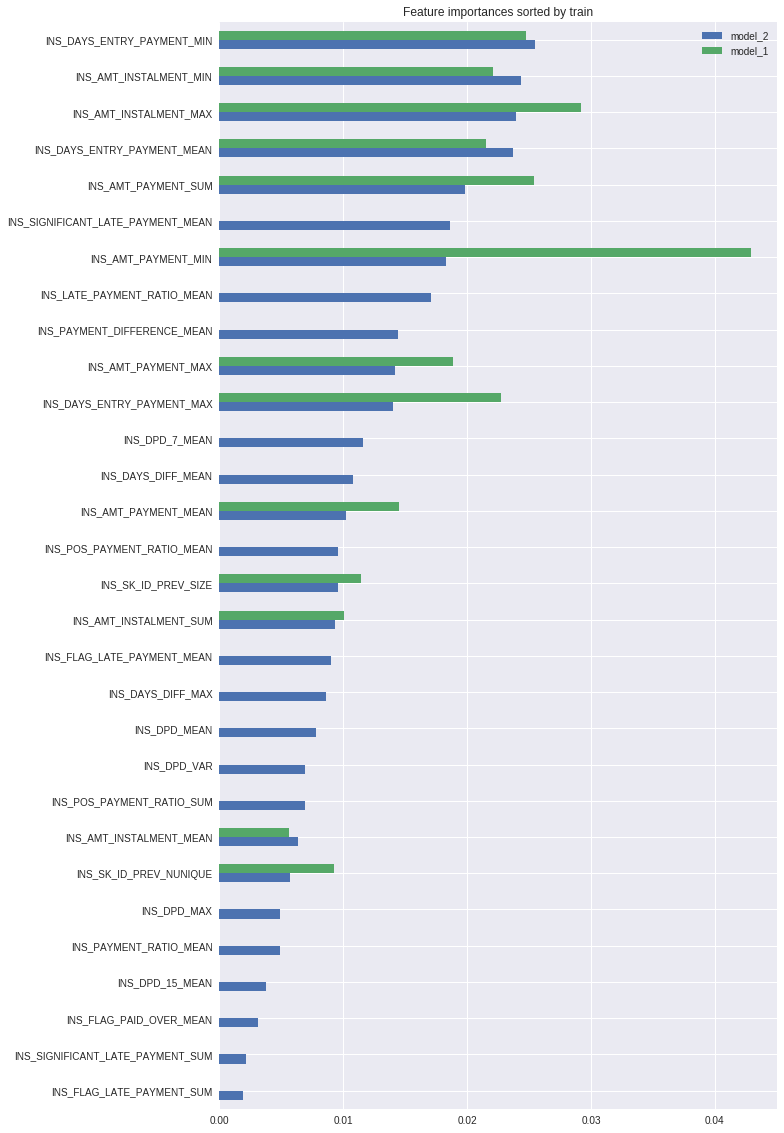

In [0]:
ax = imp.sort_values('model_2').plot.barh(
    title='Feature importances sorted by train', figsize=(10,20))

In [0]:
# Drop some less-information features
imp[imp['model_2'] == 0].index

Index([], dtype='object')